# Bag of Words and Tf-Idf
## Part 2 of the Workshop "Text Classification - From Zero to Hero", by Dr. Omri Allouche, Gong.io, Bar Ilan University

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["axes.labelsize"] = 15

In [44]:
df = pd.read_csv('data/20newsgroups.csv')
df.head()

,data,target,target_name,data_processed,num_chars
0,Oops! I came across this file from last year....,0,rec.sport.baseball,oops! i came across this file from last year ....,5944
1,"...\n\nIf we are indeed talking about CS, then...",2,talk.politics.guns,". . . if we are indeed talking about cs , then...",828
2,"I had heard the rumors about LA, Cin, Hou, and...",0,rec.sport.baseball,"i had heard the rumors about la , cin , hou , ...",195
3,\n\nYou can't think of any valid reason to own...,2,talk.politics.guns,you can't think of any valid reason to own a g...,766
4,Turkish Genocide Apology in revision <93042616...,3,talk.politics.mideast,turkish genocide apology in revision <93042616...,484


In [45]:
df['target_name'].value_counts()

rec.sport.hockey         975
rec.sport.baseball       958
talk.politics.mideast    919
talk.politics.guns       886
Name: target_name, dtype: int64

(0, 5000)

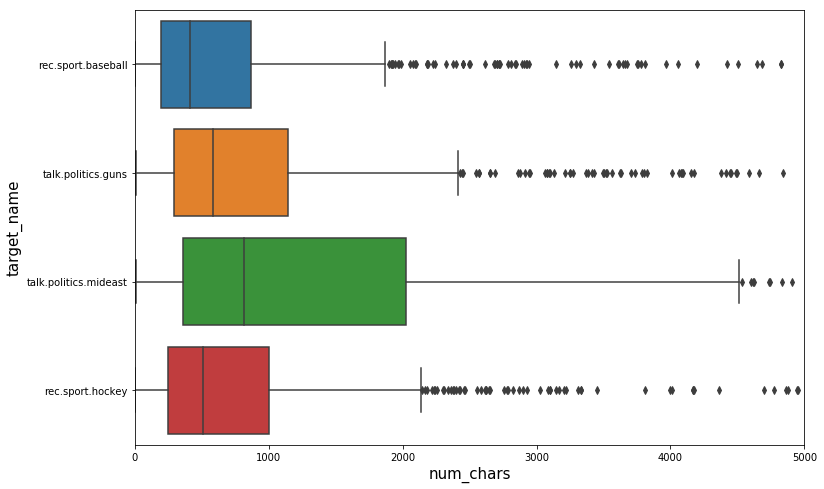

In [46]:
sns.boxplot(data=df, y='target_name', x='num_chars')
plt.xlim(0,5000)

Now let's fit a Tf-Idf vectorizer to these documents. We'll remove English stopwords, and check the words that have the highest Tfidf score for each class:

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

df_train = pd.read_csv('data/train.csv')
vectors = vectorizer.fit_transform(df_train['text'])
vectors.shape

(2617, 28616)

In [48]:
df_train['tfidf'] = list(vectors.toarray())

In [49]:
inverse_vocab = {v: k for k,v in vectorizer.vocabulary_.items()}
top_terms = df_train.groupby('label')['tfidf'].apply(lambda x: x.sum(axis=0))
for i,r in top_terms.iteritems():
    print(i)
    print([inverse_vocab[x] for x in np.argsort(r)[-20:][::-1]])
    print()

rec.sport.baseball
['year', 'game', 'baseball', 'games', 'team', 'hit', 'think', 'don', 'like', 'time', 'braves', 'just', 'good', 'runs', 'pitcher', 'know', 'players', 'pitching', 'stats', 'better']

rec.sport.hockey
['game', 'team', 'hockey', 'games', 'nhl', 'don', 'season', 'players', 'play', 'think', 'espn', 'year', 'good', 'pens', 'like', 'leafs', 'just', 'playoffs', 'time', 'know']

talk.politics.guns
['gun', 'people', 'fbi', 'guns', 'don', 'just', 'batf', 'weapons', 'right', 'know', 'law', 'government', 'like', 'think', 'koresh', 'did', 'gas', 'firearms', 'control', 'make']

talk.politics.mideast
['israel', 'jews', 'people', 'israeli', 'armenian', 'armenians', 'arab', 'turkish', 'jewish', 'said', 'just', 'arabs', 'turkey', 'don', 'did', 'government', 'like', 'muslims', 'know', 'killed']



### Basic Classifier
Next, let's build a basic classifier. Let's use the Multinomial Naive Bayes.

We'll first fit the model on the train set:

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# We use the vectorizer we fitted earlier to transform the textual string into 
vectors = vectorizer.transform(df_train['text'])
clf = MultinomialNB()
clf.fit(vectors, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

And then predict and evaluate performance on the validation set:

In [51]:
df_val = pd.read_csv('data/val.csv')
y_truth = df_val['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [52]:
metrics.f1_score(y_truth, y_predict, average='macro')

0.9207733016158028

We see that even a simple model performs pretty well. Let's examine the most important features for each class:

In [53]:
def show_top_terms(classifier, vectorizer):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i in range(len(classifier.classes_)):
        top_terms = np.argsort(classifier.coef_[i])[-20:]
        print(classifier.classes_[i])
        print(", ".join(feature_names[top_terms]))
        print()

show_top_terms(clf, vectorizer)

rec.sport.baseball
better, stats, pitching, players, know, pitcher, runs, good, just, braves, time, like, don, think, hit, team, games, baseball, game, year

rec.sport.hockey
know, time, playoffs, just, leafs, like, pens, good, year, espn, think, play, players, season, don, nhl, games, hockey, team, game

talk.politics.guns
make, control, firearms, gas, did, koresh, think, like, government, law, know, right, weapons, batf, just, don, guns, fbi, people, gun

talk.politics.mideast
killed, know, muslims, like, government, did, don, turkey, arabs, just, said, jewish, turkish, arab, armenians, armenian, israeli, people, jews, israel



Let's further examine the classification report and the confusion matrix:

In [54]:
from model_evaluation_utils import *

In [55]:
from sklearn import metrics
print(metrics.classification_report(y_truth, y_predict))

                       precision    recall  f1-score   support

   rec.sport.baseball       0.92      0.89      0.90       155
     rec.sport.hockey       0.91      0.92      0.91       153
   talk.politics.guns       0.93      0.94      0.93       125
talk.politics.mideast       0.92      0.94      0.93       127

            micro avg       0.92      0.92      0.92       560
            macro avg       0.92      0.92      0.92       560
         weighted avg       0.92      0.92      0.92       560



Normalized confusion matrix
[[0.89032258 0.08387097 0.01935484 0.00645161]
 [0.04575163 0.91503268 0.0130719  0.02614379]
 [0.024      0.         0.936      0.04      ]
 [0.01574803 0.00787402 0.03149606 0.94488189]]


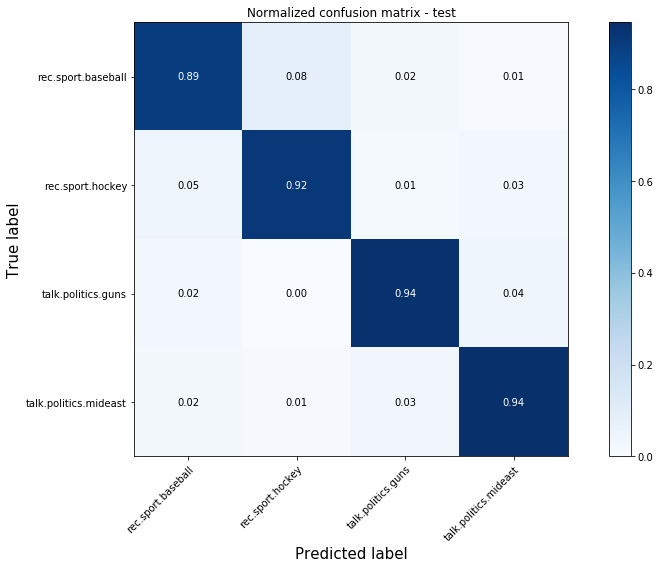

In [56]:
plot_confusion_matrix(y_truth, y_predict, normalize=True, title='Normalized confusion matrix - test');

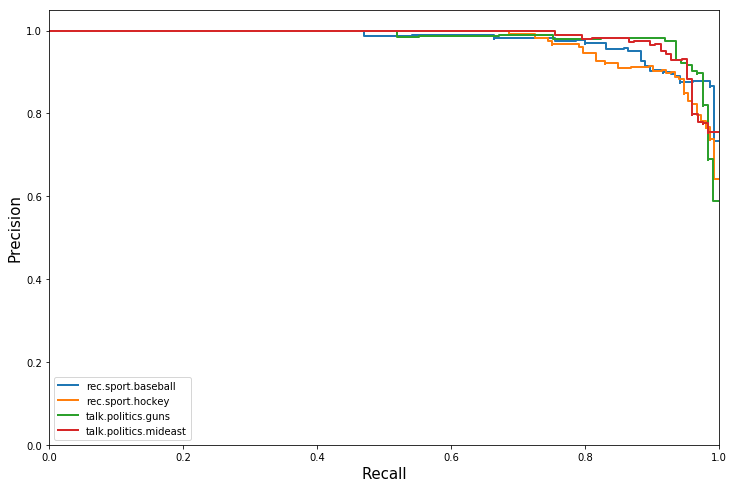

In [57]:
plot_precision_recall_curve(y_predict_proba, y_truth);

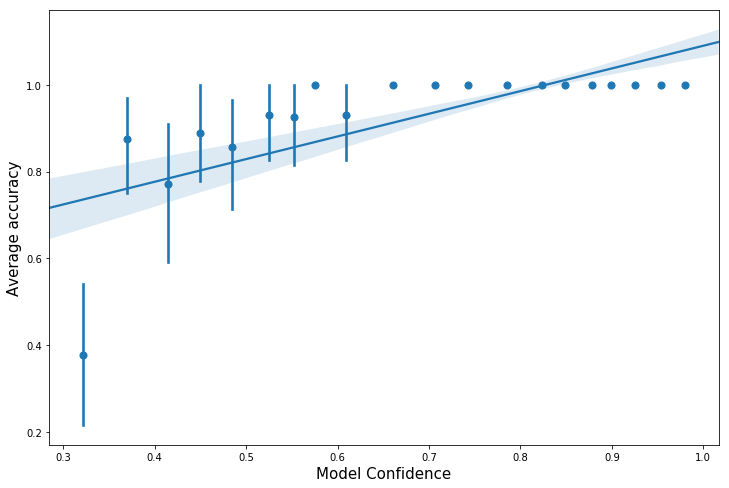

In [58]:
plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=20);

Next, let's perform an error analysis and manually review documents that are wrongly classified. We will focus on documents that have a high model confidence:

In [59]:
df_test = pd.read_csv('data/val.csv').set_index('index')
y_truth = df_test['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [60]:
df_test['y_predict'] = clf.predict(vectors_val)
df_test['y_predict_proba'] = np.max(clf.predict_proba(vectors_val))
df_test['is_error'] = (y_predict != y_truth).astype(int)

In [61]:
# df_test['doc_len'] = df_test['text'].str.len()

In [62]:
df_test.sort_values('is_error', ascending=False).head()

,data,target,label,text,num_chars,y_predict,y_predict_proba,is_error
index,,,,,,,,
201,My brother purchased baseball tickets for Texa...,0,rec.sport.baseball,my brother purchased baseball tickets for texa...,638,rec.sport.hockey,0.999192,1
1603,"\n\n\nIronic, since it's pretty much what was ...",2,talk.politics.guns,"ironic , since it's pretty much what was used ...",88,rec.sport.baseball,0.999192,1
758,\nSomeone tell me there's a :-) hidden here so...,0,rec.sport.baseball,someone tell me there's a :-) hidden here some...,228,talk.politics.guns,0.999192,1
3584,"Greetings baseballers, \n\n\tI have a choice o...",0,rec.sport.baseball,"greetings baseballers , i have a choice of two...",316,rec.sport.hockey,0.999192,1
167,\n\nWell I don't see any smileys here. I am t...,1,rec.sport.hockey,well i don't see any smileys here . i am tryin...,190,talk.politics.guns,0.999192,1


In [65]:
def print_document(r):    
    print('Document #{}. True label: {}. Predicted: {} (confidence: {:.1%})'.format(
        r.name,
        r['label'], 
        r['y_predict'],
        r['y_predict_proba']
    ))
    print()
    print(r['text'])

In [66]:
print_document(df_test.loc[411])

Document #411. True label: rec.sport.hockey. Predicted: rec.sport.hockey (confidence: 99.9%)

attention penguins fans once again , apparently 99 .999% of you understand that this was just a joke (hence the :-) next to it) but one idiot on here doesn't as he got pissed at me and sent me two hate e-mails telling me that this is wrong . i have no intentions of sending e-mail to anyone should the pens win tonight , and i really do not expect/do not intend to lead any of you to send this poster e-mail either . it was not a serious request . if you didn't know that (which you probably did) then don't do it . thanks .


(0, 3000)

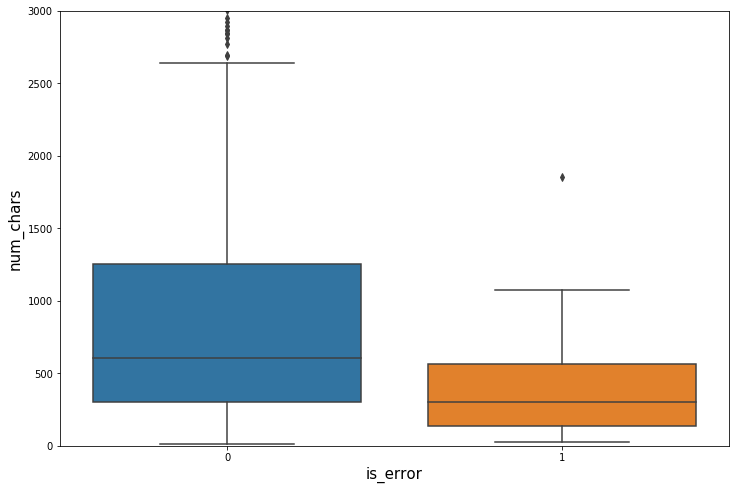

In [67]:
sns.boxplot(data=df_test, x='is_error', y='num_chars')
plt.ylim(0,3000)

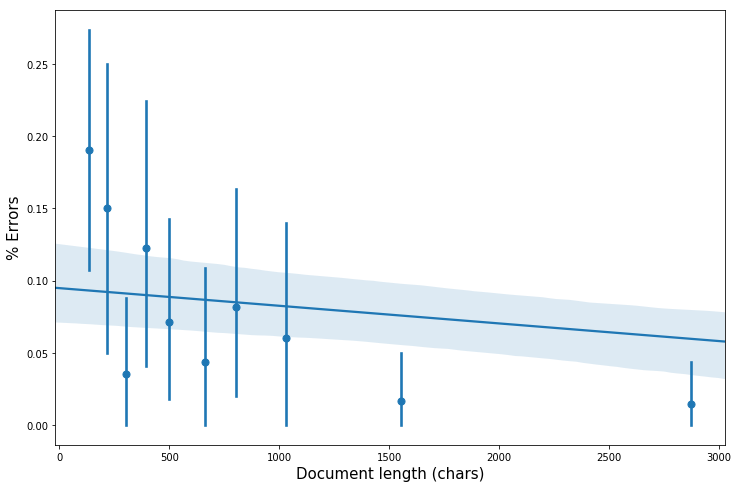

In [70]:
ax = sns.regplot(data=df_test, x='num_chars', y=df_test['is_error'], x_bins=10)
plt.xlabel('Document length (chars)');
plt.ylabel('% Errors');